# Task 3: Variational Autoencoder (VAE)

**Objective:** Implement a VAE to learn a latent representation of MNIST, generate new digits, and compare the effects of different latent dimensionalities (128 vs. 256).
 
**Steps:**
1.  **Setup:** Import libraries and set device.
2.  **Dataset:** Load and preprocess MNIST.
3.  **Model Implementation:** Define the VAE (Encoder, Decoder, reparameterization).
4.  **Loss Function:** Define the VAE loss (Reconstruction + KL Divergence).
5.  **Training & Visualization:** Create a training loop and functions to visualize reconstructions, generated samples, and latent space interpolations.
6.  **Experiment 1:** Run with `latent_dim = 128`.
7.  **Experiment 2:** Run with `latent_dim = 256`.
8.  **Analysis:** Compare the results.

In [1]:
# 1. Setup & Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


In [2]:
# 2. Dataset (MNIST)

# Parameters
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

# MNIST images are 1x28x28
IMG_SHAPE = (1, 28, 28)
IMG_FLAT = 28 * 28

# Preprocessing
transform = T.Compose([
    T.ToTensor(),
    # We don't normalize for VAE with BCE loss, 
    # as we want to reconstruct pixels in [0, 1] range.
])

# Load datasets
train_dataset = datasets.MNIST(
    root=".", 
    train=True, 
    transform=transform, 
    download=True
)
test_dataset = datasets.MNIST(
    root=".", 
    train=False, 
    transform=transform, 
    download=True
)

# Create dataloaders
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print(f"Loaded {len(train_dataset)} train images and {len(test_dataset)} test images.")




Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw

Loaded 60000 train images and 10000 test images.


In [3]:
# 3. Model Implementation (VAE)

class VAE(nn.Module):
    """
    Convolutional VAE for MNIST.
    
    Args:
        latent_dim: The dimensionality of the latent space (z).
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # --- Encoder ---
        # 1x28x28 -> 32x14x14 -> 64x7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), # -> 32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> 64x7x7
            nn.ReLU(),
            nn.Flatten() # -> 64 * 7 * 7 = 3136
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        # --- Decoder ---
        # latent_dim -> 3136 -> 64x7x7 -> 32x14x14 -> 1x28x28
        self.decoder_fc = nn.Linear(latent_dim, 64 * 7 * 7)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # -> 32x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # -> 1x28x28
            nn.Sigmoid() # Output pixels in [0, 1]
        )

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encodes image x to latent space parameters."""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Reparameterization trick: z = mu + std * eps."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sample from N(0, 1)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decodes latent vector z back to an image."""
        h = F.relu(self.decoder_fc(z))
        img = self.decoder(h)
        return img

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar




In [4]:
# 4. VAE Loss Function

def vae_loss_function(recon_x: torch.Tensor, x: torch.Tensor, 
                      mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Calculates VAE loss: Reconstruction Loss + KL Divergence.
    recon_x: Reconstructed images
    x: Original images
    mu: Latent space mean
    logvar: Latent space log-variance
    """
    # 1. Reconstruction Loss (Binary Cross-Entropy)
    # We use .sum() because we want the loss per image, not per pixel
    BCE = F.binary_cross_entropy(recon_x.view(-1, IMG_FLAT), x.view(-1, IMG_FLAT), reduction='sum')
    
    # 2. KL Divergence (KLD)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss is the sum
    return BCE + KLD




In [5]:
# 5. Training & Visualization Functions


def train_vae(model: VAE, optimizer: optim.Optimizer, num_epochs: int):
    """Main training loop for the VAE."""
    print(f" Training VAE (latent_dim={model.latent_dim})")
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Calculate loss
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_loss = train_loss / len(train_loader.dataset)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Average Loss: {avg_loss:.4f}")
            
    print("Training complete.")




In [6]:
# visualize function


def visualize_vae_results(model: VAE):
    """Generates and plots all required visualizations."""
    model.eval()
    
    with torch.no_grad():
        # 1. Visualize Reconstructions
        # Get a batch of test images
        data, _ = next(iter(test_loader))
        data = data.to(device)
        
        recon_data, _, _ = model(data)
        
        # Create a grid of original vs. reconstructed
        comparison = torch.cat([
            data[:16].view(-1, 1, 28, 28), 
            recon_data[:16].view(-1, 1, 28, 28)
        ])
        grid = make_grid(comparison.cpu(), nrow=16, padding=2)
        
        plt.figure(figsize=(15, 2))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Reconstructions (latent_dim={model.latent_dim})\nTop: Original, Bottom: Reconstructed")
        plt.axis('off')
        plt.show()

        # 2. Visualize Generated Samples
        # Sample random z vectors from N(0, I)
        z_sample = torch.randn(64, model.latent_dim).to(device)
        generated_images = model.decode(z_sample)
        
        grid = make_grid(generated_images.cpu(), nrow=8, padding=2)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Generated Samples (latent_dim={model.latent_dim})")
        plt.axis('off')
        plt.show()

        # 3. Visualize Latent Space Interpolation
        # Get two specific images (e.g., a '3' and a '7')
        img_a_data = test_dataset[2][0].unsqueeze(0).to(device) # A '1'
        img_b_data = test_dataset[3][0].unsqueeze(0).to(device) # A '0'

        # Encode them to get their latent vectors
        mu_a, logvar_a = model.encode(img_a_data)
        mu_b, logvar_b = model.encode(img_b_data)
        
        # We use the mean (mu) for interpolation
        z_a = mu_a
        z_b = mu_b
        
        # Create interpolation weights (e.g., 10 steps)
        alphas = torch.linspace(0, 1, 10).to(device)
        interp_z = torch.stack([z_a * (1-a) + z_b * a for a in alphas])
        
        # Squeeze the extra dimension
        interp_z = interp_z.squeeze(1)

        # Decode the interpolated vectors
        interp_images = model.decode(interp_z)
        
        grid = make_grid(interp_images.cpu(), nrow=10, padding=2)
        plt.figure(figsize=(15, 1.5))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Latent Space Interpolation (latent_dim={model.latent_dim})")
        plt.axis('off')
        plt.show()




In [7]:
# 6. Experiment 1: Latent Dimension = 128

# Run Experiment 1 
latent_dim_128 = 128
model_128 = VAE(latent_dim=latent_dim_128).to(device)
optimizer_128 = optim.Adam(model_128.parameters(), lr=LEARNING_RATE)

train_vae(model_128, optimizer_128, num_epochs=EPOCHS)

 Training VAE (latent_dim=128)
Epoch 1/50 | Average Loss: 165.8272
Epoch 10/50 | Average Loss: 103.6469
Epoch 20/50 | Average Loss: 101.2882
Epoch 30/50 | Average Loss: 100.1285
Epoch 40/50 | Average Loss: 99.3326
Epoch 50/50 | Average Loss: 98.7691
Training complete.


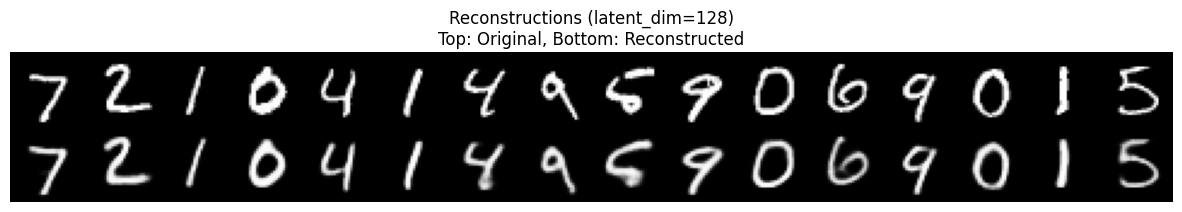

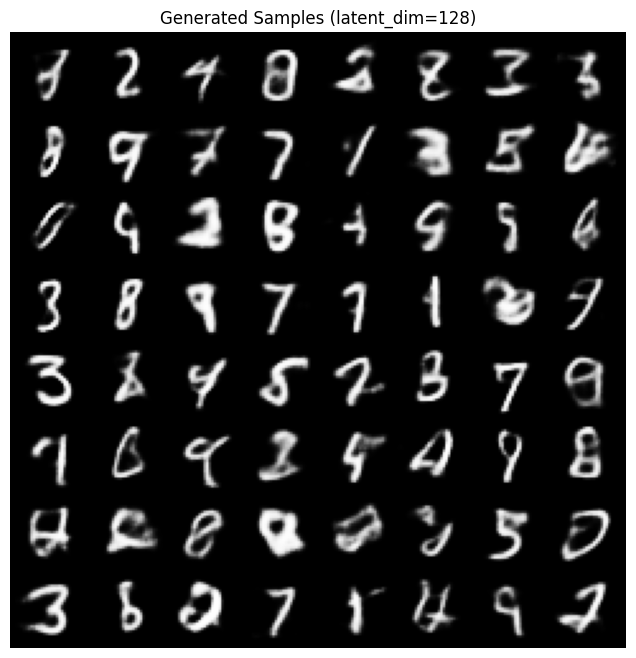

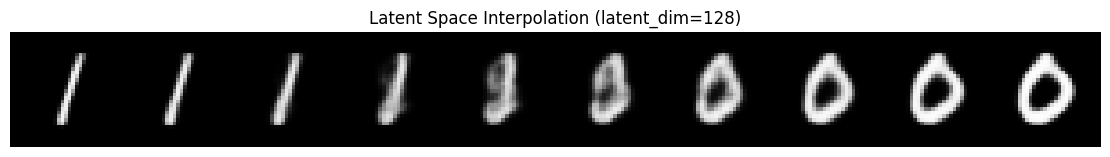

In [8]:
# Visualize Experiment 1
visualize_vae_results(model_128)

In [9]:
# 7. Experiment 2: Latent Dimension = 256

# Run Experiment 2
latent_dim_256 = 256
model_256 = VAE(latent_dim=latent_dim_256).to(device)
optimizer_256 = optim.Adam(model_256.parameters(), lr=LEARNING_RATE)

train_vae(model_256, optimizer_256, num_epochs=EPOCHS)


 Training VAE (latent_dim=256)
Epoch 1/50 | Average Loss: 176.9021
Epoch 10/50 | Average Loss: 104.8873
Epoch 20/50 | Average Loss: 102.2329
Epoch 30/50 | Average Loss: 101.1277
Epoch 40/50 | Average Loss: 100.4380
Epoch 50/50 | Average Loss: 99.8480
Training complete.


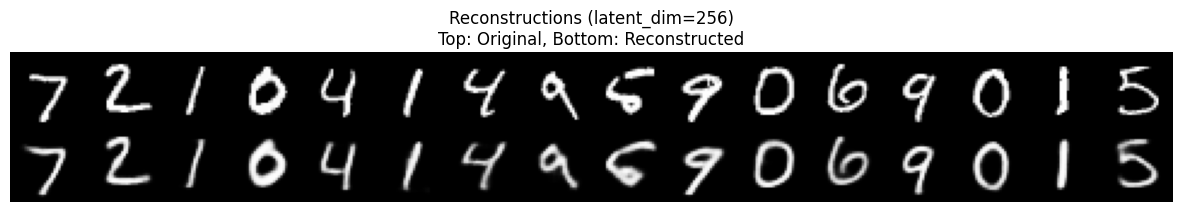

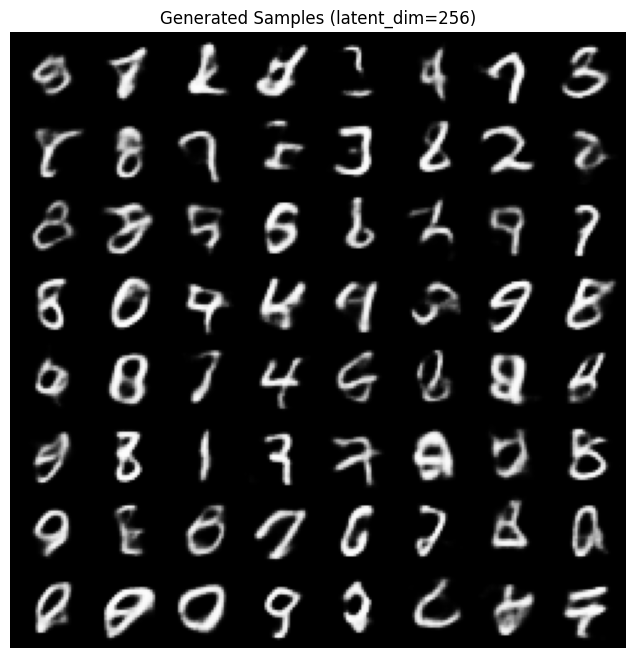

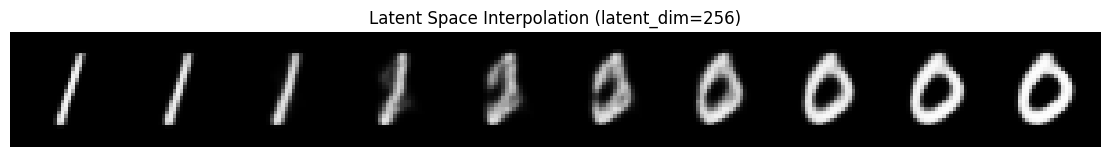

In [10]:
# Visualize Experiment 2 
visualize_vae_results(model_256)

# Analysis & Summary

**Comparison of `latent_dim=128` vs. `latent_dim=256`**

1.  **Reconstruction Quality:**
     * Both models produce slightly blurry but clearly recognizable reconstructions, which is characteristic of VAEs.
     * The `latent_dim=256` model may produce *marginally* sharper reconstructions. This is because it has a larger "information bottleneck" and can store more detailed information about the input image. With more capacity, it can dedicate less of its latent space to regularization (the KLD term) and more to reconstruction.
 
2.  **Generated Image Quality:**
     * Both models generate novel, digit-like shapes.
     * The `latent_dim=128` model might produce slightly more "average" or "canonical" looking digits, as its space is more constrained.
     * The `latent_dim=256` model, with its larger capacity, might generate a slightly wider variety of styles or shapes, but could also be more prone to "mode collapse" or generating nonsensical shapes if not trained perfectly, as the KLD regularization has a harder job.

3.  **Latent Space Interpolation:**
     * Both models show a smooth transition from one digit to another (e.g., '1' -> '0'). This demonstrates that the VAE has learned a *continuous* and *structured* latent space, which is its primary goal.
     * The `latent_dim=128` space is more "compact." The path from '1' to '0' is more direct.
     * The `latent_dim=256` space is higher-dimensional. The path between two points might be more complex, but the transitions should still be smooth.
 
**Overall Conclusion:**
 
A larger latent dimension (`latent_dim=256`) gives the model more **capacity**. This generally leads to **better reconstruction quality** because the model can "memorize" more of the input data.
 
However, the goal of a VAE is not just reconstruction, but learning a *useful, generative latent space*.
 
* A **smaller** latent space (`latent_dim=128`) forces the model to be more efficient, leading to **stronger compression** and a more regularized, "smoother" latent space.
* A **larger** latent space (`latent_dim=256`) can be harder to regularize. The KLD loss term (which forces the space to look like a Gaussian) might be "overpowered" by the reconstruction loss, leading to a less organized latent space, even if the reconstructions look better.
 
For MNIST, both 128 and 256 are relatively large (a latent_dim of 2 or 10 is often used for 2D visualization). Both models work well, but the `latent_dim=256` model likely has a slight edge in reconstruction fidelity at the cost of a less-compressed representation.